In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

import numpy as np
import seaborn as sns
import gvar as gv
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *

## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
latex_labels = ['\\mathcal{O}_1', '\\mathcal{O}_2', '\\mathcal{O}_3', '\\mathcal{O}_{1\'}', '\\mathcal{O}_{2\'}']
# colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each ensemble differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]
ainv_list = [ainv_24I, ainv_24I, ainv_32I, ainv_32I, ainv_32I]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]    # f_pi^phys = 130.4 MeV

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I = [(hbarc ** 2) / (ainv_24I[0] ** 2), 2 * (hbarc ** 2) * ainv_24I[1] / (ainv_24I[0] ** 3)]
asq_32I = [(hbarc ** 2) / (ainv_32I[0] ** 2), 2 * (hbarc ** 2) * ainv_32I[1] / (ainv_32I[0] ** 3)]
asq_list = [asq_24I, asq_24I, asq_32I, asq_32I, asq_32I]

asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

In [4]:
# propagate uncertainties
ainv24I_gv = gv.gvar(ainv_24I[0], ainv_24I[1])
ainv32I_gv = gv.gvar(ainv_32I[0], ainv_32I[1])
a24I_gv = hbarc / ainv24I_gv
a32I_gv = hbarc / ainv32I_gv
print(a24I_gv)
print(a32I_gv)

0.11061(31)
0.08284(28)


In [5]:
# print('a for 24I lattices: ' + str(hbarc / ainv_24I[0]) + ' fm')
# print('a for 32I lattices: ' + str(hbarc / ainv_32I[0]) + ' fm')
print('a for 24I lattices: ' + str(a24I_gv) + ' fm')
print('a for 32I lattices: ' + str(a32I_gv) + ' fm')

a for 24I lattices: 0.11061(31) fm
a for 32I lattices: 0.08284(28) fm


### Renormalize bare matrix elements in NPR basis

In [6]:
# get ZV
ZV_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/ZVA.h5'
fZV = h5py.File(ZV_path, 'r')
ZV_24I = fZV['ZV/24I/dist'][()]
ZV_32I = fZV['ZV/32I/dist'][()]
fZV.close()
# ZV_all = np.array([ZV_24I, ZV_24I, ZV_32I, ZV_32I, ZV_32I])

In [7]:
# get RCs for Z_ij / Z_V^2 and Z_A
rc_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/Z_pert_run.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/Z_pert_run.h5']
fRCs = [h5py.File(path, 'r') for path in rc_paths]
ZijZVsq_24I_NPR = fRCs[0]['MSbar'][()]    # (ens_idx, boot_idx, i, j) in NPR basis
ZijZVsq_32I_NPR = fRCs[1]['MSbar'][()]
[f.close() for f in fRCs]

# convert NPR --> BSM basis
k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], \
             dtype = np.float64) / 4.0
kinv = np.linalg.inv(k)
ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)

Zij_24I_BSM_dist = np.einsum('bij,b->bij', ZijZVsq_24I_BSM, ZV_24I**2)
Zij_32I_BSM_dist = np.einsum('bij,b->bij', ZijZVsq_32I_BSM, ZV_32I**2)

In [8]:
ZbyZVsq_24I_gvar = np.zeros((5, 5), dtype = object)
ZbyZVsq_32I_gvar = np.zeros((5, 5), dtype = object)
multiplets = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [1, 2], [2, 1], [3, 4], [4, 3]], dtype = object)
for mult_idx in multiplets:
    ZbyZVsq_24I_gvar[mult_idx[0], mult_idx[1]] = gv.gvar(np.mean(ZijZVsq_24I_NPR[:, mult_idx[0], mult_idx[1]]), \
                               np.std(ZijZVsq_24I_NPR[:, mult_idx[0], mult_idx[1]], ddof = 1))
    ZbyZVsq_32I_gvar[mult_idx[0], mult_idx[1]] = gv.gvar(np.mean(ZijZVsq_32I_NPR[:, mult_idx[0], mult_idx[1]]), \
                               np.std(ZijZVsq_32I_NPR[:, mult_idx[0], mult_idx[1]], ddof = 1))

In [9]:
print('24I Z / ZV^2 in MSbar: ' + str(ZbyZVsq_24I_gvar))
print('32I Z / ZV^2 in MSbar: ' + str(ZbyZVsq_32I_gvar))

24I Z / ZV^2 in MSbar: [[1.0427(11) 0 0 0 0]
 [0 1.1963(14) 0.3010(12) 0 0]
 [0 0.06081(32) 1.0965(13) 0 0]
 [0 0 0 1.0563(12) -0.02750(27)]
 [0 0 0 -0.2467(15) 1.3069(17)]]
32I Z / ZV^2 in MSbar: [[1.0713(12) 0 0 0 0]
 [0 1.2025(18) 0.31916(79) 0 0]
 [0 0.04851(21) 0.9951(17) 0 0]
 [0 0 0 0.9740(14) -0.01251(20)]
 [0 0 0 -0.2748(12) 1.3781(18)]]


In [10]:
Zij_BSM_24I = np.array([
    np.mean(Zij_24I_BSM_dist, axis = 0),
    np.std(Zij_24I_BSM_dist, axis = 0, ddof = 1)
])
Zij_BSM_32I = np.array([
    np.mean(Zij_32I_BSM_dist, axis = 0),
    np.std(Zij_32I_BSM_dist, axis = 0, ddof = 1)
])
Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [11]:
# k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], \
#              dtype = np.float64) / 4.0
# kinv = np.linalg.inv(k)
# ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
# ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)
# Zij_BSM_24I

In [12]:
# # get final mean and std for each Zij coefficient. Use for each lattice spacing
# Zij_BSM_24I = np.array([
#     np.mean(Zij_BSM[:2], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[0], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[1], axis = 0, ddof = 1) ** 2)
# ])
# Zij_BSM_32I = np.array([
#     np.mean(Zij_BSM[2:4], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[2], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[3], axis = 0, ddof = 1) ** 2)
# ])
# Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [13]:
# k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], dtype = np.float64) / 4.0
# kinv = np.linalg.inv(k)
# ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
# ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# # get mean and std for 32I to generate fake data for ml0p008
# # Z32I_mu_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
# # Z32I_std_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
# # Z_32Iml0p008 = np.zeros((n_boot, n_ops, n_ops), dtype = np.float64)
# # for i in range(n_ops):
# #     for j in range(n_ops):
# #         tmp = Superboot(2)
# #         tmp.boots = ZijZVsq_32I_BSM[:, :, i, j]
# #         Z32I_mu_BSM[i, j] = tmp.compute_mean()
# #         Z32I_std_BSM[i, j] = tmp.compute_std()
# #         Z_32Iml0p008[:, i, j] = gen_fake_ensemble([Z32I_mu_BSM[i, j], Z32I_std_BSM[i, j]], n_samples = n_boot)
# Z32I_mu_BSM = np.mean(ZijZVsq_32I_BSM, axis = 0)
# Z32I_std_BSM = np.std(ZijZVsq_32I_BSM, axis = 0, ddof = 1)

# ZijZVsq_BSM = np.zeros((n_ens, n_boot, n_ops, n_ops), dtype = np.float64)
# ZijZVsq_BSM[0] = ZijZVsq_24I_BSM[1]    # 24I/ml0p01
# ZijZVsq_BSM[1] = ZijZVsq_24I_BSM[0]    # 24I/ml0p005
# ZijZVsq_BSM[2] = Z_32Iml0p008    # 32I/ml0p008
# ZijZVsq_BSM[3] = ZijZVsq_32I_BSM[1]    # 32I/ml0p006
# ZijZVsq_BSM[4] = ZijZVsq_32I_BSM[0]    # 32I/ml0p004
# ZA = np.zeros((n_ens, n_boot), dtype = np.float64)
# ZA[0] = ZA_24I[0]
# ZA[1] = ZA_24I[1]
# ZA[2] = ZA_32I[0]
# ZA[3] = ZA_32I[1]
# ZA[4] = ZA_32I[2]

In [14]:
# select the renormalization coeffs to use
# Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)

# Uncomment here if we want to run bare matrix elements
# Zij_BSM = np.zeros((5, 50, 5, 5), dtype = np.float64)
# for a in range(n_ens):
#     for b in range(n_boot):
#         Zij_BSM[a, b] = np.eye(5)

In [15]:
# # get final mean and std for each Zij coefficient. Use for each lattice spacing
# Zij_BSM_24I = np.array([
#     np.mean(Zij_BSM[:2], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[0], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[1], axis = 0, ddof = 1) ** 2)
# ])
# Zij_BSM_32I = np.array([
#     np.mean(Zij_BSM[2:4], axis = (0, 1)), 
#     np.sqrt(np.std(Zij_BSM[2], axis = 0, ddof = 1) ** 2 + np.std(Zij_BSM[3], axis = 0, ddof = 1) ** 2)
# ])
# Zij_all = np.array([Zij_BSM_24I, Zij_BSM_24I, Zij_BSM_32I, Zij_BSM_32I, Zij_BSM_32I])

In [16]:
print('24I renormalization:\n' + str(Zij_BSM_24I[0]))
print('Error:\n' + str(Zij_BSM_24I[1]))
print(export_matrix_latex(Zij_BSM_24I[0], Zij_BSM_24I[1]))

24I renormalization:
[[ 0.60793166  0.          0.         -0.07648154  0.        ]
 [ 0.          0.52281074  0.          0.         -0.02795457]
 [ 0.          0.          0.5298767   0.          0.        ]
 [-0.06180992  0.          0.          0.55723978  0.        ]
 [ 0.          0.00798076  0.          0.          0.67810904]]
Error:
[[0.00295715 0.         0.         0.00044593 0.        ]
 [0.         0.00256013 0.         0.         0.00028468]
 [0.         0.         0.0026622  0.         0.        ]
 [0.00038946 0.         0.         0.00261048 0.        ]
 [0.         0.0002511  0.         0.         0.00332234]]
\begin{pmatrix} 0.6079(30) & 0 & 0 & -0.07648(45) & 0 \\ 0 & 0.5228(26) & 0 & 0 & -0.02795(28) \\ 0 & 0 & 0.5299(27) & 0 & 0 \\ -0.06181(39) & 0 & 0 & 0.5572(26) & 0 \\ 0 & 0.00798(25) & 0 & 0 & 0.6781(33) \end{pmatrix}


In [17]:
print('32I renormalization:\n' + str(Zij_BSM_32I[0]))
print('Error:\n' + str(Zij_BSM_32I[1]))
print(export_matrix_latex(Zij_BSM_32I[0], Zij_BSM_32I[1]))

32I renormalization:
[[ 0.67722667  0.          0.         -0.08987336  0.        ]
 [ 0.          0.54150815  0.          0.         -0.01409118]
 [ 0.          0.          0.60333129  0.          0.        ]
 [-0.05464     0.          0.          0.56045477  0.        ]
 [ 0.          0.03994275  0.          0.          0.78319644]]
Error:
[[0.00729643 0.         0.         0.0009458  0.        ]
 [0.         0.00589092 0.         0.         0.00024746]
 [0.         0.         0.00652423 0.         0.        ]
 [0.00058928 0.         0.         0.00605743 0.        ]
 [0.         0.00053199 0.         0.         0.00846271]]
\begin{pmatrix} 0.6772(73) & 0 & 0 & -0.08987(95) & 0 \\ 0 & 0.5415(59) & 0 & 0 & -0.01409(25) \\ 0 & 0 & 0.6033(65) & 0 & 0 \\ -0.05464(59) & 0 & 0 & 0.5605(61) & 0 \\ 0 & 0.03994(53) & 0 & 0 & 0.7832(85) \end{pmatrix}


#### New error propagation, mult by mean and spread boots

In [18]:
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])

a4_mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare a^4 (mat elems)
mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
Lam_chi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    # TODO changed this to see what would happen with Rp, may need to change it back
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params.h5'
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params_exc_FINAL.h5'
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params_Rp.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    mat_elems_bare_b = np.zeros((n_ops, n_boot), dtype = np.float64)
    print(config)
    for i in range(n_ops):
        mat_elems_bare_b[i] = (ainv_list[ens_idx][0] ** 4) * a4_mat_elems_raw[:, i]
        new_std = np.sqrt((4 * (ainv_list[ens_idx][0] ** 3) * np.mean(a4_mat_elems_raw[:, i]) * ainv_list[ens_idx][1]) ** 2 + ((ainv_list[ens_idx][0] ** 4) * np.std(a4_mat_elems_raw[:, i], ddof = 1)) ** 2)
        mat_elems_bare_b[i] = spread_boots(mat_elems_bare_b[i], new_std)
        a4_mat_elems_ens[ens_idx][i] = Superboot(n_ens)
        a4_mat_elems_ens[ens_idx][i].populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        mat_elems_bare[ens_idx][i].populate_ensemble(mat_elems_bare_b[i], ens_idx)
        # a4_mat_elems_ens[ens_idx][i] = a4_mat_elems_ens[ens_idx][i].scale(1 / mult_factor)    # print out original a4matelems
        print(labels[i] + ' bare: ' + str(np.mean(a4_mat_elems_raw[:, i])))
        # mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # renormalize matrix elements
    mat_elems_renorm_b = np.einsum('ij,jb->ib', Zij_all[ens_idx, 0], mat_elems_bare_b)
    new_err = np.sqrt(np.einsum('ij,j->i', Zij_all[ens_idx, 1] ** 2, np.mean(mat_elems_bare_b, axis = 1) ** 2) + \
                      np.einsum('ij,j->i', Zij_all[ens_idx, 0] ** 2, np.std(mat_elems_bare_b, axis = 1, ddof = 1) ** 2))
    for i in range(n_ops):
        mat_elems_renorm_b[i] = spread_boots(mat_elems_renorm_b[i], new_err[i])
        mat_elems_ens[ens_idx][i].populate_ensemble(mat_elems_renorm_b[i], ens_idx)
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    
#     # read in David's numbers
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)
#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     Lam_chi_ens[ens_idx] = (fpi_ens[ens_idx] ** 2).scale(8 * (np.pi ** 2))
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))
    
    # this reads in my ampi, afpi from the two point analysis
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi'][()]
    afpi_boot = twopt_data['afpi'][()]
    twopt_data.close()
    # print(np.std(ampi_boot, ddof = 1), ampi_david[ens_idx][1])
    # print(np.std(afpi_boot, ddof = 1), afpi_david[ens_idx][1])
    ampi_spread = spread_boots(ampi_boot, ampi_david[ens_idx][1])    # use David's error
    afpi_spread = spread_boots(afpi_boot, afpi_david[ens_idx][1])
    ampi_shift = shift_boots(ampi_spread, ampi_david[ens_idx][0])
    afpi_shift = shift_boots(afpi_spread, afpi_david[ens_idx][0])
    
    # confirm the shifted and spread boots have the right mean and std
    # print(np.mean(ampi_shift), ampi_david[ens_idx][0])
    # print(np.mean(afpi_shift), afpi_david[ens_idx][0])
    # print(np.std(ampi_shift, ddof = 1), ampi_david[ens_idx][1])
    # print(np.std(afpi_shift, ddof = 1), afpi_david[ens_idx][1])
    
    ampi_ens.populate_ensemble(ampi_shift, ens_idx)
    afpi_ens.populate_ensemble(afpi_shift, ens_idx)
    # ampi_ens.populate_ensemble(ampi_boot, ens_idx)
    # afpi_ens.populate_ensemble(afpi_boot, ens_idx)
    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    Lam_chi_ens[ens_idx] = (fpi_ens[ens_idx] ** 2).scale(8 * (np.pi ** 2))
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

24I/ml_0p01
O1 bare: -0.005797009124834904
O2 bare: -0.010005981223519686
O3 bare: 0.0003438153602998817
O1p bare: -0.017918349484219942
O2p bare: 0.0024408044729414577
24I/ml_0p005
O1 bare: -0.004888974116517233
O2 bare: -0.00833801627560303
O3 bare: 0.00017431076683739884
O1p bare: -0.01531847633057312
O2p bare: 0.002041806202127283
32I/ml0p008
O1 bare: -0.001857302608221866
O2 bare: -0.0029058475032599207
O3 bare: 8.308536343702598e-05
O1p bare: -0.0057761308214664695
O2p bare: 0.0007220724079382483
32I/ml0p006
O1 bare: -0.0016397345884810901
O2 bare: -0.002576874001561196
O3 bare: 5.613859451253295e-05
O1p bare: -0.005132015862562994
O2p bare: 0.0006420685153937431
32I/ml0p004
O1 bare: -0.0014780261082776597
O2 bare: -0.0023241047553323475
O3 bare: 3.400949038300284e-05
O1p bare: -0.004658341957759655
O2p bare: 0.0005801556738650936


In [19]:
for i in range(n_ens):
    print('Ensemble: ' + ensembles[i])
    print('Lambda_chi, eps_sq = ' + export_float_latex(Lam_chi_ens[i].compute_mean(), Lam_chi_ens[i].compute_std(), \
            sf = 1) + ' & ' + export_float_latex(eps_sq_ens[i].compute_mean(), eps_sq_ens[i].compute_std(), sf = 1))
    print('Lambda_chi, eps_sq_phys = '+export_float_latex(Lam_chi_ens[i].compute_mean(),Lam_chi_ens[i].compute_std(),\
            sf = 1) + ' & '+export_float_latex(eps_sq_phys_ens[i].compute_mean(),eps_sq_ens[i].compute_std(),sf = 1))

Ensemble: 24I/ml_0p01
Lambda_chi, eps_sq = 2.12(1) & 0.0878(6)
Lambda_chi, eps_sq_phys = 2.12(1) & 0.1384(6)
Ensemble: 24I/ml_0p005
Lambda_chi, eps_sq = 1.81(1) & 0.0642(5)
Lambda_chi, eps_sq_phys = 1.81(1) & 0.0868(5)
Ensemble: 32I/ml0p008
Lambda_chi, eps_sq = 2.07(2) & 0.0817(9)
Lambda_chi, eps_sq_phys = 2.07(2) & 0.1261(9)
Ensemble: 32I/ml0p006
Lambda_chi, eps_sq = 1.88(1) & 0.0686(6)
Lambda_chi, eps_sq_phys = 1.88(1) & 0.0961(6)
Ensemble: 32I/ml0p004
Lambda_chi, eps_sq = 1.72(2) & 0.0528(6)
Lambda_chi, eps_sq_phys = 1.72(2) & 0.0676(6)


#### Propagate error and print data

In [20]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
a4_mat_elems_bare_mu = np.array([[a4_mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
a4_mat_elems_bare_sigma = np.array([[a4_mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_bare_mu = np.array([[mat_elems_bare[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_bare_sigma = np.array([[mat_elems_bare[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mat_elem_mu = np.array([[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)])
mat_elem_sigma = np.array([[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)])

mpi_mu = np.array([mpi_ens[i].compute_mean() for i in range(n_ens)])
mpi_sigma = np.array([mpi_ens[i].compute_std() for i in range(n_ens)])
fpi_mu = np.array([fpi_ens[i].compute_mean() for i in range(n_ens)])
fpi_sigma = np.array([fpi_ens[i].compute_std() for i in range(n_ens)])
eps_mu = np.array([eps_sq_ens[i].compute_mean() for i in range(n_ens)])
eps_sigma = np.array([eps_sq_ens[i].compute_std() for i in range(n_ens)])
eps_phys_mu = np.array([eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)])
eps_phys_sigma = np.array([eps_sq_phys_ens[i].compute_std() for i in range(n_ens)])
ainv_ens_mu = np.array([ainv_ens[i].compute_mean() for i in range(n_ens)])
ainv_ens_sigma = np.array([ainv_ens[i].compute_std() for i in range(n_ens)])
asq_ens_mu = np.array([asq_ens[i].compute_mean() for i in range(n_ens)])
asq_ens_sigma = np.array([asq_ens[i].compute_std() for i in range(n_ens)])

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print('a^4 ' + labels[op_idx]+' bare: ' + str(a4_mat_elems_bare_mu[ens_idx][op_idx]) + ' \pm ' \
              + str(a4_mat_elems_bare_sigma[ens_idx][op_idx]) + ' (GeV)^4')
        print(labels[op_idx]+' bare: '+str(mat_elem_bare_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_bare_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
        print(labels[op_idx]+' renorm: '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.431043352674778 \pm 0.001413560086757563 GeV
f_pi: 0.16372869802363 \pm 0.0006548326452035073 GeV
epsilon_pi_sq: 0.08778196170053712 \pm 0.0006425050999079086
epsilon_pi_phys_sq (to plot at): 0.13835606956189003 \pm 0.0006154961404030495
a^4 O1 bare: -0.005797009124834903 \pm 4.0546506878410055e-05 (GeV)^4
O1 bare: -0.0587196399736888 \pm 0.0007759053276471866 (GeV)^4
O1 renorm: -0.02181610410806895 \pm 0.0005414361115775999 (GeV)^4
a^4 O2 bare: -0.010005981223519686 \pm 8.919595403557541e-05 (GeV)^4
O2 bare: -0.10135357774605873 \pm 0.0014516765320287798 (GeV)^4
O2 renorm: -0.05367987749808711 \pm 0.0008021749935081145 (GeV)^4
a^4 O3 bare: 0.0003438153602998818 \pm 1.4895118999075123e-06 (GeV)^4
O3 bare: 0.0034826086589622414 \pm 4.185655635237829e-05 (GeV)^4
O3 renorm: 0.0018453531864430907 \pm 2.403868501719472e-05 

In [21]:
# Table 2: dimensionless bare matrix elements
col_labels = ['\\rule{0cm}{0.4cm}Ensemble', '$a m_\\ell$']
for i in range(n_ops):
    col_labels.append('$a^4 \\langle \\pi^+ | ' + latex_labels[i] + ' | \\pi^- \\rangle$')
col_labels = np.array(col_labels)
# row_labels = np.array([['\\rule{0cm}{0.4cm} 24I', '0.01'], ['24I', '0.005'], ['\\rule{0cm}{0.4cm} 32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
row_labels = np.array([['\\rule{0cm}{0.4cm}\multirow{2}{*}{24I}', '0.01'], [' ', '0.005'], ['\\rule{0cm}{0.4cm}\multirow{3}{*}{32I}', '0.008'], [' ', '0.006'], [' ', '0.004']])
a4matelems_fmt = Table(a4_mat_elems_bare_mu, is_entry = False, sigma = a4_mat_elems_bare_sigma)
a4_mat_elems_table = export_vert_table_latex(a4matelems_fmt, col_labels, row_labels = row_labels, hline_idxs = [0, 2], \
                                             header = '\\begin{tabular}{ cc | ccccc } \\hline \\hline ')
print('Format string for dimensionless mat elems table')
print(a4_mat_elems_table)

Format string for dimensionless mat elems table
\begin{tabular}{ cc | ccccc } \hline \hline \rule{0cm}{0.4cm}Ensemble & $a m_\ell$ & $a^4 \langle \pi^+ | \mathcal{O}_1 | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_2 | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_3 | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_{1'} | \pi^- \rangle$ & $a^4 \langle \pi^+ | \mathcal{O}_{2'} | \pi^- \rangle$ \\  \hline \rule{0cm}{0.4cm}\multirow{2}{*}{24I} & 0.01 & -0.005797(41) & -0.010006(89) & 0.0003438(15) & -0.01792(13) & 0.002441(22) \\   & 0.005 & -0.004889(37) & -0.00834(10) & 0.0001743(14) & -0.01532(12) & 0.002042(26) \\  \hline \rule{0cm}{0.4cm}\multirow{3}{*}{32I} & 0.008 & -0.001857(17) & -0.002906(33) & 0.00008309(48) & -0.005776(53) & 0.0007221(82) \\   & 0.006 & -0.001640(15) & -0.002577(33) & 0.00005614(36) & -0.005132(47) & 0.0006421(80) \\   & 0.004 & -0.001478(14) & -0.002324(30) & 0.00003401(23) & -0.004658(45) & 0.0005802(75) \\  \hline \hline \end{tabular} 


In [22]:
# Table 3: dimensionless bare matrix elements (add in ncfgs column)
col_labels = ['\\rule{0cm}{0.4cm}Ensemble', '$a m_\\ell$']
mat_elem_mu_array = np.array([[mat_elem_mu[ens_idx][op_idx] for op_idx in range(n_ops)] for ens_idx in range(n_ens)])
mat_elem_sigma_array = np.array([[mat_elem_sigma[ens_idx][op_idx] for op_idx in range(n_ops)] for ens_idx in range(n_ens)])
for i in range(n_ops):
    col_labels.append('$\\langle \\pi^+ | ' + latex_labels[i] + '^{\\overline{\\mathrm{MS}}} | \\pi^- \\rangle\;(\\mathrm{GeV}^4)$')
col_labels = np.array(col_labels)
# row_labels = np.array([['\\rule{0cm}{0.4cm} 24I', '0.01'], ['24I', '0.005'], ['\\rule{0cm}{0.4cm} 32I', '0.008'], ['32I', '0.006'], ['32I', '0.004']])
row_labels = np.array([['\\rule{0cm}{0.4cm}\multirow{2}{*}{24I}', '0.01'], [' ', '0.005'], ['\\rule{0cm}{0.4cm}\multirow{3}{*}{32I}', '0.008'], [' ', '0.006'], [' ', '0.004']])
matelems_fmt = Table(mat_elem_mu_array, is_entry = False, sigma = mat_elem_sigma_array)
a4_mat_elems_table = export_vert_table_latex(matelems_fmt, col_labels, row_labels = row_labels, hline_idxs = [0, 2], \
                                             header = '\\begin{tabular}{ cc | ccccc } \\hline \\hline ')
print('Format string for renormalized mat elems table')
print(a4_mat_elems_table)

Format string for renormalized mat elems table
\begin{tabular}{ cc | ccccc } \hline \hline \rule{0cm}{0.4cm}Ensemble & $a m_\ell$ & $\langle \pi^+ | \mathcal{O}_1^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_2^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_3^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_{1'}^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ & $\langle \pi^+ | \mathcal{O}_{2'}^{\overline{\mathrm{MS}}} | \pi^- \rangle\;(\mathrm{GeV}^4)$ \\  \hline \rule{0cm}{0.4cm}\multirow{2}{*}{24I} & 0.01 & -0.02182(54) & -0.05368(80) & 0.001845(24) & -0.0975(14) & 0.01596(26) \\   & 0.005 & -0.01824(47) & -0.04473(77) & 0.000936(14) & -0.0834(12) & 0.01335(25) \\  \hline \rule{0cm}{0.4cm}\multirow{3}{*}{32I} & 0.008 & -0.02378(85) & -0.0510(10) & 0.001614(29) & -0.1010(20) & 0.01447(39) \\   & 0.006 & -0.02090(75) & -0.04521(96) & 0.001090(2

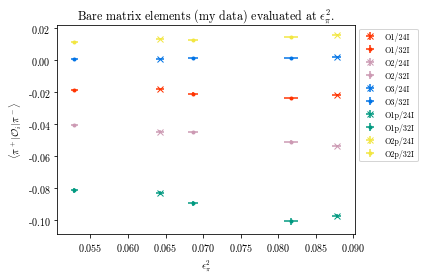

In [23]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
markers = ['v', 'v', '.', '.', '.']
plt.figure()
for i in range(n_ops):
#     plt.errorbar(eps_phys_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
#     plt.errorbar(eps_phys_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
    plt.errorbar(eps_mu[:2], [mat_elem_mu[j][i] for j in range(n_ens)][:2], xerr = eps_phys_sigma[:2], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][:2], fmt = 'x', c = colors[i], label = labels[i] + '/24I')
    plt.errorbar(eps_mu[2:], [mat_elem_mu[j][i] for j in range(n_ens)][2:], xerr = eps_phys_sigma[2:], yerr = [mat_elem_sigma[j][i] for j in range(n_ens)][2:], fmt = '.', c = colors[i], label = labels[i] + '/32I')
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('$\\langle \pi^+ | \mathcal{O}_i | \pi^- \\rangle$')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
# plt.xlim((0.025, 0.045))
# plt.ylim((0.015, 0.029))
# plt.title('Renormalized matrix elements evaluated at $\epsilon_\pi^2|_{f_0}$.')

# plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
# plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')

plt.title('Bare matrix elements (my data) evaluated at $\epsilon_\pi^2$.')
plt.tight_layout()
plt.show()

## Perform the fit

In [24]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)

In [25]:
# Define functional fit forms for the operators
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

For a given operator $\mathcal O^k$, this should be changed to a correlated fit between $(m_\pi, f_\pi, \mathcal O^k)$ on each ensemble. The covariance matrix will be 15 x 15 ($n_{ens}$ times len($(m_\pi, f_\pi, \mathcal O^k)$)) block-diagonal matrix, where each block is $3\times 3$. 

In [26]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [27]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O1
[-10.15169835  -1.4180702   -0.37361672]
O2
[ 5.5109151  -2.79599836 -1.02207719]
O3
[1.2193417  0.47021466 0.09727083]
O1p
[-3.48690807 -6.08508868 -1.03383118]
O2p
[12.42409912  0.77321143 -1.40335287]


#### Fit to full data

In [28]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

Operator O1
Ensemble 0, boot 0
-10.148842258663478 -1.4145710837498733 -0.42278169186327647
Ensemble 0, boot 1
-10.268960057331306 -1.4307634599639674 -0.39209067810850046
Ensemble 0, boot 2
-10.470780014885253 -1.4467268222712792 -0.5397140357758563
Ensemble 0, boot 3
-10.441047825009335 -1.449192440483312 -0.4173961728263557
Ensemble 0, boot 4
-10.142983728598798 -1.4175609595145646 -0.36260435490781023
Ensemble 0, boot 5
-10.56741050585436 -1.4509918404449944 -0.6271610419589896
Ensemble 0, boot 6
-10.781722336535347 -1.4687038639653829 -0.7316112647234809
Ensemble 0, boot 7
-10.134996138682038 -1.4191484574544093 -0.3106412141193612
Ensemble 0, boot 8
-10.257700825437515 -1.4288097864178557 -0.3985218615403189
Ensemble 0, boot 9
-11.057981633383545 -1.5026540950414757 -0.7986184603763327
Ensemble 0, boot 10
-10.452303405207878 -1.451389445278342 -0.39737353232173483
Ensemble 0, boot 11
-9.775652315732557 -1.3820653699289907 -0.26342110817588466
Ensemble 0, boot 12
-10.0353437064414

-10.453215695048987 -1.4200184217435288 -0.33102564599655643
Ensemble 2, boot 5
-10.137750077784265 -1.4183258411094353 -0.37599755872985163
Ensemble 2, boot 6
-10.417111132217837 -1.4140744867029815 -0.33083617030677587
Ensemble 2, boot 7
-9.785490857394183 -1.4055074838158217 -0.4169233248024663
Ensemble 2, boot 8
-12.98887860662489 -1.4380291363767659 0.0390211576683487
Ensemble 2, boot 9
-9.002278815051902 -1.405600522637383 -0.5309578128139608
Ensemble 2, boot 10
-10.481926843576371 -1.4123543318376852 -0.318704692114953
Ensemble 2, boot 11
-10.48069478520292 -1.42359635808782 -0.32970955031059074
Ensemble 2, boot 12
-11.218496646120705 -1.4261575483859519 -0.22272810700798684
Ensemble 2, boot 13
-9.65786158955943 -1.4114797372278116 -0.4404743506813643
Ensemble 2, boot 14
-11.213475312635882 -1.4223266424731693 -0.21825564048793905
Ensemble 2, boot 15
-5.4054197854399035 -1.4119302147605977 -1.0691707186369717
Ensemble 2, boot 16
-7.359296411881147 -1.4150322782196638 -0.78094609

-10.552640735312426 -1.4645714977566546 -0.5235956339121365
Ensemble 4, boot 9
-10.164649239550117 -1.4194861140973074 -0.3973804261128151
Ensemble 4, boot 10
-10.643017005334777 -1.4751137550825444 -0.5454215132938727
Ensemble 4, boot 11
-10.326683226412838 -1.4378226912488234 -0.4436117900529409
Ensemble 4, boot 12
-9.935552786593508 -1.3950680028763458 -0.2580264917075766
Ensemble 4, boot 13
-9.784294606032608 -1.3754475223477687 -0.20532785996482142
Ensemble 4, boot 14
-9.468896824522734 -1.3444773320365748 -0.09348392936130408
Ensemble 4, boot 15
-9.917367536155314 -1.3923476096397605 -0.25975229930935684
Ensemble 4, boot 16
-11.014243788616396 -1.5158786626589376 -0.7483995246000654
Ensemble 4, boot 17
-10.457165321839868 -1.4527296464439605 -0.4635801587931843
Ensemble 4, boot 18
-10.100706440704665 -1.411758270854869 -0.41791464726286676
Ensemble 4, boot 19
-10.563287084070474 -1.4655598313242244 -0.5015349836795538
Ensemble 4, boot 20
-10.361289880532201 -1.4418185437629114 -0

7.634042557435227 -2.855150951056483 -1.4178521860681499
Ensemble 1, boot 14
7.32592523669618 -2.8373103506067743 -1.3511329740085083
Ensemble 1, boot 15
6.048600240818202 -2.810300990150026 -1.1219383343721991
Ensemble 1, boot 16
4.684552578688694 -2.7896717316476924 -0.8830837246548284
Ensemble 1, boot 17
3.5893100915881466 -2.769032427801029 -0.684836402899373
Ensemble 1, boot 18
2.736711393080782 -2.7411541746301027 -0.5188573226232543
Ensemble 1, boot 19
5.452208224478829 -2.8514930544777064 -1.0676114573231716
Ensemble 1, boot 20
5.297112987628758 -2.82985827944319 -1.0211475651691382
Ensemble 1, boot 21
4.684767513830311 -2.785532106505956 -0.8788876229538236
Ensemble 1, boot 22
5.053524621416732 -2.755712496090378 -0.9081876694169564
Ensemble 1, boot 23
4.32337999765471 -2.759166974695063 -0.7943320562344668
Ensemble 1, boot 24
4.904434646015618 -2.7652399071468508 -0.8939016537089391
Ensemble 1, boot 25
8.543802060024433 -2.8508882588054525 -1.560140547706535
Ensemble 1, boot 

6.066940071867829 -2.7695984256407593 -1.0417058803773864
Ensemble 3, boot 20
6.123186438319384 -2.759690671930412 -1.043227616939382
Ensemble 3, boot 21
6.348937356410115 -2.747611756069971 -1.0492856939431694
Ensemble 3, boot 22
4.072117326394559 -2.824653491908996 -0.952939653332135
Ensemble 3, boot 23
6.34930114084217 -2.7649281395521585 -1.0513273062911228
Ensemble 3, boot 24
5.920070753025634 -2.7860912915391185 -1.036959487708994
Ensemble 3, boot 25
4.236275646982119 -2.8354598468443184 -0.9669754918619238
Ensemble 3, boot 26
4.381568646070796 -2.831871743199516 -0.9654291399985954
Ensemble 3, boot 27
5.552090757655522 -2.7786620131899706 -1.0222268854272647
Ensemble 3, boot 28
5.627567164594025 -2.792494652078497 -1.0273101001083527
Ensemble 3, boot 29
7.393253161030992 -2.712716107094515 -1.0785669888554237
Ensemble 3, boot 30
4.44151039405841 -2.8474068242141204 -0.976151473052607
Ensemble 3, boot 31
5.986866354685664 -2.7684875690702158 -1.0386519043488707
Ensemble 3, boot 3

2.4473418866488674 0.4557947693354786 0.5932429594011055
Ensemble 0, boot 26
-0.42709883004778243 0.4909873017076378 -0.720908018583447
Ensemble 0, boot 27
1.6368173033341484 0.4652406028580197 0.2857165531419865
Ensemble 0, boot 28
1.225002962978118 0.4700404809337763 0.03735820043876192
Ensemble 0, boot 29
1.0582777254018372 0.4719899438342863 -0.15097204843095965
Ensemble 0, boot 30
1.8679758683176035 0.4625526347781618 0.44854313651174005
Ensemble 0, boot 31
1.935064406067475 0.4614832080609012 0.24957001133068307
Ensemble 0, boot 32
0.3143926250698192 0.4811744076474036 -0.341883005573691
Ensemble 0, boot 33
-1.7703629774971807 0.5072939635518497 -1.2639407248573156
Ensemble 0, boot 34
1.263649659089001 0.4691645411778087 -0.05533918921996362
Ensemble 0, boot 35
0.8177282144584429 0.4751485473006485 -0.11487101885511146
Ensemble 0, boot 36
1.9376858006842121 0.4616707071254434 0.3811982963402839
Ensemble 0, boot 37
1.2543070134248375 0.4698940080136962 0.1885535451967478
Ensemble 

-0.08887527147993714 0.4791587628026807 0.18545810824059833
Ensemble 2, boot 31
-0.36443330556177816 0.47243120754133827 0.33746088557242887
Ensemble 2, boot 32
3.227256942912651 0.472356276086516 -0.294629106614832
Ensemble 2, boot 33
3.607015318266877 0.4735501586238711 -0.3586259381042461
Ensemble 2, boot 34
1.3995294517756949 0.4726523595217652 0.023210075081445916
Ensemble 2, boot 35
0.628161662072252 0.4630752289873762 0.3173198606425475
Ensemble 2, boot 36
3.960253880168596 0.46403568344670637 -0.2952544918832646
Ensemble 2, boot 37
2.253024400510008 0.46460068924246867 0.013467143864998424
Ensemble 2, boot 38
0.13825542285044398 0.4637668498207834 0.39033478556724255
Ensemble 2, boot 39
2.6682417658401194 0.4694116838207871 -0.13646678895530487
Ensemble 2, boot 40
3.234799543520837 0.4743556107710806 -0.3193629823636444
Ensemble 2, boot 41
3.072896801442834 0.473948281585334 -0.28242171609465777
Ensemble 2, boot 42
1.41114517806257 0.4746562223899987 -0.009781305952083907
Ensem

0.7222771404458758 0.4777234261437952 -0.006015329305229111
Ensemble 4, boot 36
0.3797668377046659 0.48763971888956864 -0.5773273584022194
Ensemble 4, boot 37
0.623896142065097 0.48316623480569804 -0.4516149085243111
Ensemble 4, boot 38
0.6861138164669516 0.4783130366450201 -0.04813911290147605
Ensemble 4, boot 39
0.05074033662472227 0.4916765894518393 -0.5821526060320514
Ensemble 4, boot 40
0.9232834861824053 0.4772662944946605 -0.2504281317621874
Ensemble 4, boot 41
0.010039226814006853 0.49322436953315973 -0.6117293629114227
Ensemble 4, boot 42
1.1404220328556829 0.4703006334635317 0.17984736880100793
Ensemble 4, boot 43
1.4145478406647483 0.4650280881309346 0.45575840645838617
Ensemble 4, boot 44
0.07632838256648224 0.49092370832411647 -0.5031965660367024
Ensemble 4, boot 45
0.6994126122074198 0.47985977965625504 -0.2220449942335283
Ensemble 4, boot 46
2.0203348137665422 0.4556399176977459 0.5830186776354503
Ensemble 4, boot 47
1.4476424931593728 0.4675045643513232 0.10526685419037

-6.727770438722602 -5.957393536262163 -0.4703186264217086
Ensemble 1, boot 41
-4.617187073236569 -6.080560046117123 -0.8498333598458419
Ensemble 1, boot 42
-2.9427766985215973 -6.087700761793254 -1.12154858437726
Ensemble 1, boot 43
-3.5954174129878145 -6.052339794880349 -1.0065094595213857
Ensemble 1, boot 44
-3.19688505908999 -6.07537013970481 -1.0768423857293246
Ensemble 1, boot 45
0.5554324486425047 -6.261575297639569 -1.728836892051528
Ensemble 1, boot 46
-1.661896478506658 -6.202862021443753 -1.3608300446742339
Ensemble 1, boot 47
-1.1507937362573917 -6.1820812030347385 -1.4358710184440093
Ensemble 1, boot 48
-4.561419132512435 -6.024162595424231 -0.8423240648896676
Ensemble 1, boot 49
-2.1252587905608014 -6.123360306854382 -1.2632439738686916
Ensemble 2, boot 0
-2.8605494135714142 -6.101534878980289 -1.1347599669680435
Ensemble 2, boot 1
-5.1068728014172375 -6.037017749029288 -0.7652006541083439
Ensemble 2, boot 2
-3.9021274096525858 -6.042964106378849 -0.9566929467130275
Ensemb

-3.5762673923563955 -6.013574175911021 -1.0275666243962343
Ensemble 3, boot 47
-6.146219153881297 -6.369239909255035 -0.8912422041867389
Ensemble 3, boot 48
-2.089645303720158 -5.985579577589557 -1.0864834360031441
Ensemble 3, boot 49
-3.4506095035863527 -6.112939642097701 -1.035455738969016
Ensemble 4, boot 0
-4.140488603852172 -6.335896201846886 -1.1968917389272669
Ensemble 4, boot 1
-3.559864492417949 -6.112335104599234 -1.0066699459996076
Ensemble 4, boot 2
-3.5969603478933636 -6.125732283595514 -1.045308027504121
Ensemble 4, boot 3
-3.9566049134967365 -6.267605983606606 -1.1389925497427777
Ensemble 4, boot 4
-3.2497026903091752 -5.99350305108399 -0.9514197475525253
Ensemble 4, boot 5
-3.74083990480458 -6.184507277494678 -1.0503002548290465
Ensemble 4, boot 6
-3.5903185271895732 -6.125219730485453 -1.0361407424432647
Ensemble 4, boot 7
-3.2970107947165093 -6.00843610566889 -0.9229534944932186
Ensemble 4, boot 8
-3.687062819776497 -6.161333387726606 -1.0771870653056022
Ensemble 4, b

14.009005328227468 0.7795722520119238 -1.7019073168393972
Ensemble 1, boot 3
8.9790006432915 0.7540290280657834 -0.7171166928554367
Ensemble 1, boot 4
11.127728015351883 0.7547335059272818 -1.093644548346415
Ensemble 1, boot 5
13.45282562144282 0.7821194894357185 -1.6205656080811943
Ensemble 1, boot 6
14.314125167816988 0.7904526902006647 -1.8019021010953262
Ensemble 1, boot 7
12.947669856660013 0.7749159607691846 -1.499722462440573
Ensemble 1, boot 8
10.87955015291877 0.7676268656568791 -1.1126916886987555
Ensemble 1, boot 9
11.176323500132193 0.76872946737093 -1.1688638594329241
Ensemble 1, boot 10
11.746678003052914 0.7876023081767696 -1.3546002005776867
Ensemble 1, boot 11
13.396943329914523 0.7732421662793783 -1.5690751070330058
Ensemble 1, boot 12
10.746549954433275 0.758575547189499 -1.046052424446169
Ensemble 1, boot 13
14.794046818719432 0.795434151529885 -1.9064245723869773
Ensemble 1, boot 14
14.410760364571868 0.7890757563655375 -1.8123325134701183
Ensemble 1, boot 15
12.93

10.877856723707543 0.7905366801300383 -1.338045174900174
Ensemble 3, boot 10
11.29963678482692 0.780371963016784 -1.3550900456857315
Ensemble 3, boot 11
14.404883400347458 0.7551980716842598 -1.4744227667731393
Ensemble 3, boot 12
14.10975215350647 0.7573413137519265 -1.4631102159997849
Ensemble 3, boot 13
11.745705228482223 0.7784330007916955 -1.3746524033700962
Ensemble 3, boot 14
15.321843538275285 0.7452976074396864 -1.5000874945451712
Ensemble 3, boot 15
11.395740720764234 0.7821350468212094 -1.366443099938015
Ensemble 3, boot 16
13.833593917189527 0.7602351560530042 -1.457829409167306
Ensemble 3, boot 17
11.661152471908828 0.7812696683118987 -1.3747385220817145
Ensemble 3, boot 18
11.358069806584096 0.7809635098804124 -1.3557990399028845
Ensemble 3, boot 19
13.240140934294542 0.7641036997201756 -1.4339215552029716
Ensemble 3, boot 20
13.212617001691077 0.7622617560646202 -1.4318523591038066
Ensemble 3, boot 21
13.422013492649457 0.7593436329047917 -1.4378831425063825
Ensemble 3, 

#### Print mean and std for bootstrapped fit parameters

In [29]:
# chi2_boots[0].compute_mean() / 2

In [30]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

Fit parameters for operator O1
alpha = -10.146317985978843 \pm 3.6434868260291435
beta = -1.4178507470412371 \pm 0.09112189153293145
c = -0.3668945115259216 \pm 0.6580861344924763
Fit parameters for operator O2
alpha = 5.52163000762487 \pm 3.2008055927949646
beta = -2.7954576590609688 \pm 0.1478804569399395
c = -1.0167661249298454 \pm 0.5210258434309162
Fit parameters for operator O3
alpha = 1.2282809587354515 \pm 3.4112844481837503
beta = 0.4702230121797471 \pm 0.02040315197145414
c = 0.10307608912447204 \pm 0.8349972315343219
Fit parameters for operator O1p
alpha = -3.4815439926304825 \pm 2.722746007187562
beta = -6.084116780206477 \pm 0.2874301684209376
c = -1.029825382799295 \pm 0.46451986802163325
Fit parameters for operator O2p
alpha = 12.44631686013153 \pm 3.9028688844891906
beta = 0.7730669614059448 \pm 0.047602509877708185
c = -1.3973833769488366 \pm 0.5926036017062108


#### Get error on data and print subtracted matrix elements

In [31]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.014875175247962556 \pm 0.0008512121399833552
<pi|O2|pi> = -0.02902806951249745 \pm 0.0013618319608285376
<pi|O3|pi> = 9.12251428054871e-05 \pm 3.177783692995642e-06
<pi|O1p|pi> = -0.06316512045825497 \pm 0.0026344438462592
<pi|O2p|pi> = 0.007978689634452148 \pm 0.0004424872166994576


#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

In [32]:
# callat_colors = ['limegreen', 'deepskyblue', 'r', 'g', 'midnightblue']    # use for comparison purposes
# colors = ['r', 'g', 'b', 'c', 'y']

In [33]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
# epsilon_sq_range = m_range ** 2 / (16 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
# eps_sq_0 = mpi_0[0] ** 2 / (16 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
#             eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (16 * (np.pi**2) \
#                                                             * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

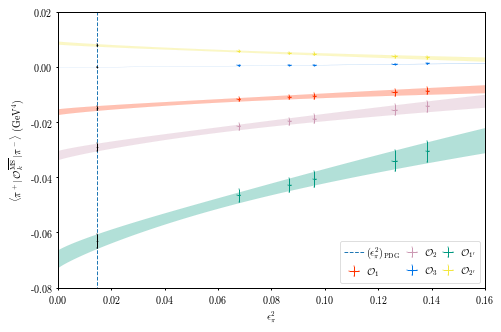

In [36]:
# plot the extrapolation
markers = ['o', 'v', '^', '_', 'x']
# style = styles['prd_twocol']
style = styles['prd_twocol*']
scale = 1        # scale factor to compare to CalLat if we want
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_{1\'} $', '$\mathcal{O}_{2\'} $']
with sns.plotting_context('paper'):
    #plt.figure(figsize = (10, 6))
    #asp_ratio = 4/3
    asp_ratio = 3/2
    plt.figure(figsize = (style['colwidth'], style['colwidth'] / asp_ratio))
    for j in range(n_ops):
        _, caps, _ = plt.errorbar(eps_sq_sub_mu, scale * np.array(mat_elems_sub_mu[j]), xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                     c = colors[j], fmt = markers[j], label = labels[j], capsize = style['endcaps'], elinewidth = style['ebar_width'], \
                     markersize = style['markersize'])
        plt.fill_between(epsilon_sq_range[1:], scale * np.array(band_data_mu[j]) + band_data_sigma[j], scale * np.array(band_data_mu[j]) - band_data_sigma[j], \
                        color = colors[j], alpha = 0.3, linewidth = 0.1)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
    plt.vlines(eps_sq_0, -0.1, 0.02, linestyles = 'dashed', label = '$(\epsilon^2_\pi)_{\mathrm{PDG}}$', linewidth = style['ebar_width'])
    _, caps, _ = plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], scale * np.array(O_phys_mu), yerr = O_phys_sigma, \
                 c = 'k', fmt = markers[j], capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
    for cap in caps:
        cap.set_markeredgewidth(style['ecap_width'])
#     plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize'] * 0.9}, ncol = 3, handletextpad = 0.2, columnspacing = 1.0)
    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', prop={'size': style['fontsize']}, ncol = 3, handletextpad = 0.2, columnspacing = 0.1)
    plt.xlim((0.0, 0.16))
    plt.ylim((-0.08, 0.02))
    #plt.ylim((-0.1, 0.02))
    plt.xticks(fontsize = style['fontsize'])
    plt.yticks(fontsize = style['fontsize'])
    plt.xlabel('$\epsilon_\pi^2$', fontsize = style['fontsize'])
    plt.ylabel('$\\langle \pi^+| \, \mathcal{O}_k^{\overline{\mathrm{MS}}} \, |\pi^- \\rangle$ (GeV$^4$)', fontsize = style['fontsize'])
    ax = plt.gca()
    ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    for spine in spinedirs:
        ax.spines[spine].set_linewidth(style['axeswidth'])
    plt.tight_layout()
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/renorm_chiral_extrap.pdf', bbox_inches='tight')
    #plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/renorm_chiral_extrap_Rp.pdf', bbox_inches='tight')
    plt.show()

In [37]:
# format output table
out_col_labels = np.array(['\\rule{0cm}{0.4cm}Operator', '$\\alpha_k$ ($\\mathrm{fm}^{-2}$)', '$\\beta_k$', '$c_k$', \
            '$\\langle\\pi^+ |\\mathcal{O}_k | \\pi^-\\rangle$ ($\\mathrm{GeV}^4$)', '$\\chi^2 / \\mathrm{dof}$'])
out_hor_labels = np.array(['$' + label + '$' for label in latex_labels])
# out_hor_labels[0] = '\\rule{0cm}{0.4cm}' + out_hor_labels[0]
out_means = np.array([alpha_mu, beta_mu, c_mu, O_phys_mu]).T
out_sigma = np.array([alpha_sigma, beta_sigma, c_sigma, O_phys_sigma]).T
param_table = Table(out_means, is_entry = False, sigma = out_sigma)
chi2_ndof_means = np.array([chi2_ndof.compute_mean() for chi2_ndof in chi2_ndof_boots])
chi2_table = Table(chi2_ndof_means, is_entry = False)
full_table = param_table.insert_cols({4 : chi2_table})
print(export_vert_table_latex(full_table, out_col_labels, out_hor_labels, hline_idxs = [0], \
                              header = '\\begin{tabular}{ c | ccc | c | c } \\hline \\hline '))

\begin{tabular}{ c | ccc | c | c } \hline \hline \rule{0cm}{0.4cm}Operator & $\alpha_k$ ($\mathrm{fm}^{-2}$) & $\beta_k$ & $c_k$ & $\langle\pi^+ |\mathcal{O}_k | \pi^-\rangle$ ($\mathrm{GeV}^4$) & $\chi^2 / \mathrm{dof}$ \\  \hline $\mathcal{O}_1$ & -10.1(3.6) & -1.418(91) & -0.37(66) & -0.01488(85) & 0.26 \\ $\mathcal{O}_2$ & 5.5(3.2) & -2.80(15) & -1.02(52) & -0.0290(14) & 0.40 \\ $\mathcal{O}_3$ & 1.2(3.4) & 0.470(20) & 0.10(83) & 0.0000912(32) & 0.25 \\ $\mathcal{O}_{1'}$ & -3.5(2.7) & -6.08(29) & -1.03(46) & -0.0632(26) & 0.54 \\ $\mathcal{O}_{2'}$ & 12.4(3.9) & 0.773(48) & -1.40(59) & 0.00798(44) & 0.36 \\  \hline \hline \end{tabular} 


## Compare contribution of short-distance to long-distance

The relevant equations that we need for this part are the half-lives of the short-distance vs long-distance decays. The long-distance decay can be ripped out of David's paper:
$$
    (T_{1/2}^{\mathrm{LD}})^{-1} = |m_{\beta\beta}|^2 G_{0\nu} |M^{0\nu}|^2
$$
where $m_{\beta\beta}$ is the neutrino Majorana mass. **Note that this parameterization absorbs factors of $G_F^2$ into the phase space factor $G_{0\nu}$, and we should re-parameterize it as $G_{0\nu} = G_F^4 \tilde G_{0\nu}$ to get a comparable between the SD and LD pieces.** Likewise, the short-distance decay can be parameterized as (PHYSICAL REVIEW C 88, 037303 (2013)):
$$
    (T_{1/2}^{\mathrm{SD}})^{-1} = \sum_k G_{0\nu}^k |M^{0\nu}_k|^2 \eta_k^2
$$
where $\eta_k$ are the new-physics parameters (this is where the Wilson coefficients come in), $G_{0\nu}^k$ are phase space factors, and $M^{0\nu}_k$ are the nuclear matrix elements. Let's simplify this by:
- Assuming that $\tilde G_{0\nu}\sim G_{0\nu}^k$ (this might end up being an equality, since the initial and final states are the same)
- Page 22 of Vincenzo's master formula paper (1806.02780) for the power counting of $m_{\beta\beta}$. In the caption to Table 3, he mentions that:
$$
    m_{\beta\beta}\sim O(v^2 / \Lambda_\mathrm{LNV}).
$$
- Working with the Lagrangian
    \begin{equation}
        \mathcal L_\mathrm{SMEFT}^{0\nu\beta\beta} = \overline{e} e^\mathrm{c} \frac{G_F^2}{\Lambda_\mathrm{LNV}} \sum_k c_k \mathcal O_k.
    \end{equation}
    we can determine that the $\eta_k$ are related to the Wilson coefficients by:
    $$
        \eta_k = \frac{G_F^2}{\Lambda_\mathrm{LNV}} c_k.
    $$
    So, we need to get the Wilson coefficients $c_k$. 

One option to compute is the ratio of half-lives, which ends up simplifying to
$$
    (T_{1/2}^{\mathrm{SD}})^{-1} / (T_{1/2}^{\mathrm{LD}})^{-1} = \frac{1}{v^4} \frac{\sum_k |c_k|^2 |\langle \pi | \mathcal O_k | \pi\rangle |^2}{|M^{0\nu}|^2}
$$
Note there are no $m_{\beta\beta}$ or $\Lambda_\mathrm{LNV}$ dependences because we assumed they're on the same order, so they cancel out. Note that here $v$ is the Higgs vev, which is:
$$
    v = 247\;\mathrm{GeV}.
$$

**Instead, let's consider the ratio of decay amplitudes.** This is because the decay is unphysical and half-life might make it a bit confusing (the phase space factors $G$ are 0 for this decay, so if we consider the ratio of half-lives we're dividing 0 by 0). In that case, we have:
$$
    \bigg|\frac{A_\mathrm{SD}}{A_\mathrm{LD}}\bigg| = \frac{1}{v^2}\frac{\sum_k |c_k \langle \pi | \mathcal O_k | \pi\rangle |}{|M^{0\nu}|}. 
$$
I think computing this is more clear, since the phase space factors are 0 for the decay since it's unphysical.

Now we need to get the $c_k$. The first place to examine should be Section 6 of the master formula paper. If that doesn't turn it up, keep digging. Note that Cirigliano parameterizes the effective Lagrangian as:
$$
\mathcal L_{\Delta L = 2} = \frac{1}{v^5}\sum_i (C_{iR}^{(9)} e_R^c e_R + C_{iL}^{(9)} e_L^c e_L) O_i
$$
whereas our parameterization is $G_F^2 / \Lambda_{LNV}\sum_k c_k \mathcal{O}_k$, hence:
$$
    c_k \sim \frac{\Lambda_{LNV}}{G_F^2} \frac{1}{v^5} (C_{iR}^{(9)} + C_{iL}^{(9)})
$$
We can use the approximation $\Lambda_{LNV}\sim v^2/m_{\beta\beta}$ as well. The Wilson coefficients from the mLRSM are about:
$$
    C_i \sim (v / \Lambda_i^{(9)})^5
$$
where $\Lambda_i^{(9)}$ are on the order of $10\;\mathrm{TeV}\sim 10^5\;\mathrm{GeV}$. 

In [41]:
v = gv.gvar(246.0, 0.0)    # GeV, Higgs vev
# mββ = 10e-12    # GeV, approx of 10 meV found on page 17 of 2202.01787
Lambda_i = gv.gvar(1e5, 0.0)

# g_nu = −10.78(12)stat(4)ﬁt(50)FV(9)
gnu_mu = -10.78
gnu_sdev = np.sqrt((0.12)**2 + (0.04)**2 + (0.5)**2 + (0.09)**2)
gnu = gv.gvar(gnu_mu, gnu_sdev)

# M^{0ν} = 0.01880(6)(2)(10)(2) GeV^2
M0nu_mean = 0.01880
M0nu_sdev = np.sqrt((6e-5)**2 + (2e-5)**2 + (1e-4)**2 + (2e-5)**2)
M0nu = gv.gvar(M0nu_mean, M0nu_sdev)    # GeV^2

# <π|O_k|π>
SD_MEs = np.array([gv.gvar(out_means[k, 3], out_sigma[k, 3]) for k in range(n_ops)])    # GeV^4
SD_MEs_abs = np.array([gv.gvar(np.abs(out_means[k, 3]), out_sigma[k, 3]) for k in range(n_ops)])    # GeV^4

In [54]:
# get the Wilson coefficients
# ck = np.array([gv.gvar(), gv.gvar(), gv.gvar(), gv.gvar(), gv.gvar()])
# ck = np.array([gv.gvar('1(0)'), gv.gvar('1(0)'), gv.gvar('1(0)'), gv.gvar('1(0)'), gv.gvar('1(0)')])
GF = gv.gvar(1e-5, 0.0)   # GeV^{-2}
Ck = np.array([(v / Lambda_i)**5 for k in range(n_ops)])

# C5 = 
mββ = 0.1e-9    # GeV
Lambda_LNV = (v**2) / mββ
ck = Lambda_LNV / (GF**2 * (v**5)) * Ck

ck_abs = np.array([gv.gvar(np.abs(x.mean), x.sdev) for x in ck])
amp_ratio = np.sum(ck_abs * SD_MEs_abs) / ((v**2) * M0nu)
print('|A_{SD} / A_{LD}| = ' + str(amp_ratio))

|A_{SD} / A_{LD}| = 0.0000612(17)


### LEC $g_i^{\pi\pi}$ determination

$$
    O_k\propto \frac{\beta_k \Lambda_{\chi 0}^4}{(4\pi)^2}
$$
for $k\in \{1, 2, 1', 2'\}$, and for $\mathcal O_3$ there is an additional factor of $\epsilon_\pi^2$. The chiral Lagrangian in Cirigliano's paper is:
$$
    \mathcal L = \frac{F_0^2}{2} \left( \frac{5}{3} g_3^{\pi\pi} C_{3} \partial_\mu \pi \partial^\mu\pi + (g_1^{\pi\pi} C_1 + g_1^{\prime \pi \pi} C_1' - g_2^{\pi\pi} C_2 - g_2^{\prime \pi\pi} C_2') \right)
$$
where I've translated the bases, as that paper uses the operator basis $[O3, O2, O2', O1, O1']$. I'm not sure what the $C_i$ coefficients end up being. Here $F_0$ is the pion decay constant in the chiral limit, and $\Lambda_{\chi 0} = 4\pi F_0$. Note they also use the conventions that $F_{phys} = 92.2$ MeV. We see that (if $C_i = 1$, idk how to get them though)
\begin{align}
    \frac{F_0^2}{2} g_1 = \frac{\beta_1 \Lambda_{\chi 0}^4}{(4\pi)^2} = \beta_1 (4\pi)^2 F_0^4 \\
    \implies F_0^2 = \frac{C_1 g_1}{2\beta_1 (4\pi)^2} = \frac{C_1' g_1'}{2\beta_1' (4\pi)^2} = -\frac{C_2 g_2}{2\beta_2 (4\pi)^2} = -\frac{C_2' g_2'}{2\beta_2' (4\pi)^2} = \frac{5C_3 g_3}{6 \epsilon_\pi^2 \beta_3 (4\pi)^2}
\end{align}

In [ ]:
callat_betas = np.array([-1.76, -3.43, 0.924, -6.68, 1.12])
callat_cs = np.array([1.7, 1.1, 2.8, 1.6, -1.5])
cirigliano_gs = np.array([-1.9, 2., 0.36, -8., -0.62])    # GeV^2

In [ ]:
cirigliano_gs / (callat_betas * 2 * (4*np.pi)**2)

We now wish to extract the correlation matrix between the different fit coefficients $\{\alpha^k\}$, $\{\beta^k\}$, and $\{c^k\}$. In the uncorrelated fit, each fit coefficient is computed for each bootstrap on each ensemble to generate an ensemble of fit parameters $\{\alpha^k_{ib}\}$, $\{\beta^k_{ib}\}$, $\{c^k_{ib}\}$, where $k$ is the operator index, $i$ is the ensemble index, and $b$ is the bootstrap index. The ensemble index is uncorrelated, so one can compute the mean and standard deviation of each LEC, for each ensemble. For example, for $\alpha^k$:
\begin{align}
   \overline{\alpha^k_i} = \frac{1}{n_b} \sum_{b} \alpha^k_{ib} && 
   (\delta\alpha^k_i)^2 = \frac{1}{n_b - 1} \sum_b (\alpha_{ib}^k - \overline{\alpha^k_i})^2
\end{align}
These can then be combined into a mean and standard deviation for each LEC, by adding them as uncorrelated variables over their ensemble index:
\begin{align}
    \overline{\alpha^k} = \frac{1}{n_{ens}}\sum_i \overline{\alpha^k_i} && (\delta\alpha^k)^2 = \sum_i (\delta\alpha^k_i)^2
\end{align}

The other statistical information that we would like to obtain from these LECs is their correlation coefficients, where the correlation between two random variables $X$ and $Y$ is defined as the normalized covariance matrix:
$$
    \mathrm{Corr}(X, Y) = \frac{\mathrm{Cov}(X, Y)}{\sigma(X)\sigma(Y)}
$$
The covariance between two LECs (for example $\alpha^k$ and $\beta^\ell$) can be computed ensemble-wise as:
$$
    \mathrm{Cov}_i(\alpha^k, \beta^\ell) = \frac{1}{n_b - 1} \sum_b (\alpha^k_{ib} - \overline{\alpha^k_i}) (\beta^\ell_{ib} - \overline{\beta^\ell_i})
$$
and then summed across ensembles, as the ensemble index is uncorrelated:
$$
    \mathrm{Cov}(\alpha^k, \beta^\ell) = \sum_i \mathrm{Cov}_i(\alpha^k, \beta^\ell).
$$
The correlation can then be assembled:
$$
    \mathrm{Corr}(\alpha^k, \beta^\ell) = \frac{\mathrm{Cov}(\alpha^k, \beta^\ell)}{(\delta\alpha^k)(\delta\beta^\ell)}
$$

In [ ]:
# Get the correlation matrix between the matrix elements, and between the LECs
alpha_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
beta_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
c_boots = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for k in range(n_ops):
    alpha_boots[k], beta_boots[k], c_boots[k] = alpha[k].boots, beta[k].boots, c[k].boots
LECs = np.concatenate((alpha_boots, beta_boots, c_boots))
n_LECs = LECs.shape[0]
Cov_ens = np.zeros((n_LECs, n_LECs, n_ens))
LECs_ens_mu = np.mean(LECs, axis = 2)
LECs_mu, LECs_sigma = np.zeros((n_LECs), dtype = np.float64), np.zeros((n_LECs), dtype = np.float64)
for k in range(n_LECs):
    LECs_mu[k] = np.mean(LECs[k])
    LECs_sigma[k] = np.sqrt(np.sum(np.std(LECs[k], axis = 1, ddof = 1) ** 2))
# sanity check that LECs_mu and LECs_sigma agrees with previous computation
for k, l in itertools.product(range(n_LECs), repeat = 2):
    for i in range(n_ens):
        Cov_ens[k, l, i] = np.sum((LECs[k, i] - LECs_ens_mu[k, i]) * (LECs[l, i] - LECs_ens_mu[l, i])) / (n_boot - 1)
Cov = np.sum(Cov_ens, axis = 2)
Corr = np.zeros(Cov.shape, dtype = np.float64)
for k, l in itertools.product(range(n_LECs), repeat = 2):
    Corr[k, l] = Cov[k, l] / (LECs_sigma[k] * LECs_sigma[l])

In [ ]:
# Labels for each LEC
end_label = ['1', '2', '3', '1\'', '2\'']
LECs_label = ['$\\alpha^' + end_label[k] + '$' for k in range(n_ops)]
LECs_label.extend(['$\\beta^' + end_label[k] + '$' for k in range(n_ops)])
LECs_label.extend(['$c^' + end_label[k] + '$' for k in range(n_ops)])
for k in range(15):
    print(LECs_label[k], end = ' ')

In [ ]:
# Print correlation matrix in blocks
label_blocks = ['Corr(α, α)', 'Corr(α, β)', 'Corr(α, c)', 'Corr(β, β)', 'Corr(β, c)', 'Corr(c, c)']
index_blocks = [0, 5, 10, 15]    # regions where one LEC stops and another begins
counter = 0
for i, j in itertools.product(range(3), repeat = 2):
    if i > j: 
        continue
    ridx_1, ridx_2 = index_blocks[i], index_blocks[i + 1]
    cidx_1, cidx_2 = index_blocks[j], index_blocks[j + 1]
    subCorr = Corr[ridx_1 : ridx_2, cidx_1 : cidx_2]
    print(label_blocks[counter] + '\n' + export_matrix_latex(subCorr, sf = 3) + '\n')
    counter += 1

## Correlated fit

Here we'll perform a correlated Bayesian fit. On each ensemble, the operator $\mathcal O^{ke}$, the pion mass $m_\pi^e$, and the pion decay constant $f_\pi^e$ are correlated. For now, we'll neglect the correlation between the operator and $(m_\pi, f_\pi)$, but perform a fit taking into account the correlation between $(m_\pi, f_\pi)$. The $\chi^2$ for each operator is:
$$
    \chi^2_k(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}, \vec \alpha, \vec \beta, \vec c) = \chi^2_{obj, k}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}, \alpha^{ke}, \beta^{ke}, c^{ke}) + \chi^2_{prior}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)})
$$
Here $\vec m_{prior}^{(k)} = (m_{prior}^{ek})$ is a vector of parameters for each ensemble (same with $\vec f_{prior}^{(k)}$), and $\vec \alpha = (\alpha^k)$ is a vector of parameters for each operator (same with $\vec\beta$ and $\vec c$). The pion mass and decay constant are allowed to float for each operator to include their correlation with $O$, although the final result we use for the pion mass and decay constant will remain the central values that we have already computed. 

The first term is written in terms of,
$$
    \Delta O^{k} = \begin{pmatrix} 
        \overline{O}^{k1} - \mathcal{F}_k(m_{prior}^{1k}, f_{prior}^{1k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k2} - \mathcal{F}_k(m_{prior}^{2k}, f_{prior}^{2k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k3} - \mathcal{F}_k(m_{prior}^{3k}, f_{prior}^{3k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k4} - \mathcal{F}_k(m_{prior}^{4k}, f_{prior}^{4k}, \alpha^k, \beta^k, c^k) \\
        \overline{O}^{k5} - \mathcal{F}_k(m_{prior}^{5k}, f_{prior}^{5k}, \alpha^k, \beta^k, c^k)
    \end{pmatrix}
$$
where $\overline{O}^{ke}$ is the central value for operator $O^k$ on ensemble $e$, and $\mathcal F_k$ is the functional form for the operator. The objective $\chi^2$ function $\chi^2_{obj, k}$ is defined as,
$$
    \chi^2_{obj, k} = \left(\Delta O^{k}\right)^T \Sigma_k^{-1} \Delta O^k,
$$
where $\Sigma_k$ is the covariance matrix between the operators on each different ensemble,
$$
    \Sigma_k = \mathrm{diag}\left( (\delta O^{k1})^2, (\delta O^{k2})^2, (\delta O^{k3})^2, (\delta O^{k4})^2, (\delta O^{k5})^2 \right),
$$
where $(\delta\mathcal O^{ke})^2$ is the variance of operator $k$ on ensemble $e$, computed over each bootstrap.

The prior $\chi^2$ tells us about the correlation between $m_\pi$ and $f_\pi$. Here the deviation vector is:
$$
\vec y^{(k)} = \begin{pmatrix}
    \overline{m}_\pi^{1} - m_{prior}^{1k} \\ 
    \overline{f}_\pi^{1} - f_{prior}^{1k} \\
    \overline{m}_\pi^2 - m_{prior}^{2k} \\
    ... \\
    \overline{f}_\pi^5 - m_{prior}^{5k}
\end{pmatrix}
$$
where the $\overline{\cdot}$ again denotes the central value over bootstraps. This vector is 10 dimensional, and we can combine it into a $\chi^2$ by considering the covariance:
$$
    \Sigma_{prior} = \mathrm{diag} \left( \mathrm{Cov}_1, \mathrm{Cov}_2, \mathrm{Cov}_3, \mathrm{Cov}_4, \mathrm{Cov}_5 \right)
$$
where $\mathrm{Cov}_e$ is the $2\times 2$ covariance matrix computed between $m_\pi$ and $f_\pi$ on ensemble $e$,
$$
    \mathrm{Cov}_e = \begin{pmatrix}
        (\delta m_\pi^e)^2 && \frac{1}{n_b - 1}\sum_b (m_\pi^{eb} - \overline{m_\pi^e}) (f_\pi^{eb} - \overline{f_\pi^e}) \\
        \frac{1}{n_b - 1}\sum_b (m_\pi^{eb} - \overline{m_\pi^e}) (f_\pi^{eb} - \overline{f_\pi^e}) && (\delta f_\pi^e)^2)
    \end{pmatrix}.
$$
These are combined into a correlated $\chi^2$ for the prior:
$$
    \chi^2_{prior}(\vec m_{prior}^{(k)}, \vec f_{prior}^{(k)}) = \vec{y}^{(k)T} \Sigma_{prior}^{-1} \vec y^{(k)}
$$

#### Resave the data in an easier format to use, it's an absolute mess right now

In [ ]:
# get matrix elements
ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
bare_mat_elems = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
renorm_mat_elems = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for k in range(n_ops):
    for i in range(n_ens):
        bare_mat_elems[k, i] = mat_elems_bare[i][k].boots[i]
        renorm_mat_elems[k, i] = mat_elems_ens[i][k].boots[i]

In [ ]:
# get two point functions
mpi_boots_full = np.zeros((n_ens, n_boot), dtype = np.float64)
fpi_boots_full = np.zeros((n_ens, n_boot), dtype = np.float64)
for ens_idx, config in enumerate(ensembles):
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/'+config+'/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi'][()]
    afpi_boot = twopt_data['afpi'][()]
    twopt_data.close()
    ampi_boot_shift = shift_boots(spread_boots(ampi_boot, ampi_david[ens_idx][1]), ampi_david[ens_idx][0])
    afpi_boot_shift = shift_boots(spread_boots(afpi_boot, afpi_david[ens_idx][1]), afpi_david[ens_idx][0])
    ampi_bar, δampi = np.mean(ampi_boot_shift), np.std(ampi_boot_shift, ddof = 1)
    afpi_bar, δafpi = np.mean(afpi_boot_shift), np.std(afpi_boot_shift, ddof = 1)
    new_mpi_err = np.sqrt((δampi ** 2)*(ainv_list[ens_idx][0] ** 2) + (ampi_bar ** 2)*(ainv_list[ens_idx][1] ** 2))
    new_fpi_err = np.sqrt((δafpi ** 2)*(ainv_list[ens_idx][0] ** 2) + (afpi_bar ** 2)*(ainv_list[ens_idx][1] ** 2))
    ampi_boot_shift = ainv_list[ens_idx][0] * ampi_boot_shift
    afpi_boot_shift = ainv_list[ens_idx][0] * afpi_boot_shift
    mpi_spread = spread_boots(ampi_boot_shift, new_mpi_err)
    fpi_spread = spread_boots(afpi_boot_shift, new_fpi_err)
    mpi_boots_full[ens_idx] = mpi_spread
    fpi_boots_full[ens_idx] = fpi_spread

In [ ]:
# write_out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/chi_extrap_data.h5'
# fw = h5py.File(write_out_file, 'w')
# fw['bare_mat_elems'] = bare_mat_elems
# fw['renorm_mat_elems'] = renorm_mat_elems
# fw['mpi'] = mpi_boots_full
# fw['fpi'] = fpi_boots_full
# fw['ainv'] = np.array(ainv_list)
# fw.close()

In [ ]:
# renorm_mat_elems, mpi_boots_full, fpi_boots_full
O_cv = np.mean(renorm_mat_elems, axis = 2)
Sigma_obj_diag = np.std(renorm_mat_elems, ddof = 1, axis = 2) ** 2
Sigma_obj = np.array([np.diag(Sigma_obj_diag[k]) for k in range(n_ops)])
Sigma_obj_inv = np.array([np.linalg.inv(Sigma_obj[k]) for k in range(n_ops)])

In [ ]:
mpi_cv = np.mean(mpi_boots_full, axis = 1)
fpi_cv = np.mean(fpi_boots_full, axis = 1)
Sigma_prior_blocks = np.array([get_covariance(np.array([mpi_boots_full[e], fpi_boots_full[e]]).T) \
                               for e in range(n_ens)])
Sigma_prior = np.zeros((2 * n_ens, 2 * n_ens), dtype = np.float64)
for e in range(n_ens):
    Sigma_prior[2*e : 2*(e + 1), 2*e : 2*(e + 1)] = Sigma_prior_blocks[e]
Sigma_prior_inv = np.linalg.inv(Sigma_prior)

In [ ]:
# def chi2_obj(LECs, mprior, fprior, a_sq, O_val, Sigma_inv):
#     # LECs = 15 dim vector [alpha^1, ..., alpha^5, beta^k, c^k]
#     # mprior, fprior = 5 dim vector for each ensemble
#     val = 0.
#     alphas, betas, cs = LECs[:5], LECs[5:10], LECs[10:15]
#     for k in range(n_ops):
#         fv_fn = get_fv_fn(k)
#         fv = np.array([fv_fn(mprior[e], L_cfgs[e], ainv_list[e][0]) for e in range(n_ens)])
#         Ok_val = O_val[k]
#         DelOk = np.array([Ok_val[e] - O_list[k](alphas[k], betas[k], cs[k], mprior[e], fprior[e], a_sq[e][0], fv[e]) \
#                               for e in range(n_ens)], dtype = np.float64)
#         val += DelOk.T @ Sigma_inv[k] @ DelOk
#     return val
# def chi2_prior(mprior, fprior, mvals, fvals, Sigma_inv):
#     """
#     mprior: mpi_{prior}^e, should be a n_ens dim vector which is minimized
#     fprior: fpi_{prior}^e, should be a n_ens dim vector which is minimized
#     mvals: central values for m_pi^e from the bootstrap, should be a n_ens dim vector
#     fvals: central values for f_pi^e from the bootstrap, should be a n_ens dim vector
#     Sigma_inv: Inverse covariance matrix between (mpi, fpi) on each ensemble. Should be (2n_ens) x (2n_ens), and 
#         2x2 block diagonal.
#     """
#     delM = mprior - mvals
#     delF = fprior - fvals
#     y = np.zeros((10), dtype = np.float64)
#     y[0::2] = delM
#     y[1::2] = delF
#     return y.T @ Sigma_inv @ y
# def corr_chi2(x, a_sq, O_val, mvals, fvals, Sigma_obj_inv, Sigma_prior_inv):
#     """
#     x = [alpha1, ..., alpha_5, beta_1, ..., beta_5, c1, ..., c5, m1, ..., m5, f1, ..., f5]. Note that for the 
#     LECs, the index is for each operator, but for the mpi, fpi the index is for each ensemble
#     """
#     LECs = x[:15]
#     mprior, fprior = x[15:20], x[20:25]
#     return chi2_obj(LECs, mprior, fprior, a_sq, O_val, Sigma_obj_inv) \
#                                 + chi2_prior(mprior, fprior, mvals, fvals, Sigma_prior_inv)
# LEC_guess = np.array([-1.3, 10.3, 6.2, -1.5, 7.7, -1.7, -5.0, 0.6, -5.5, 1.3, -0.8, -1.1, 1.7, -1.1, -1.1])
# x_guess = np.append(LEC_guess, np.append(mpi_cv, fpi_cv))

In [ ]:
def chi2_obj(k, LECs, mprior, fprior, a_sq, O_val, Sigma_inv):
    # LECs = 3 dim vector [alpha^k, beta^k, c^k]
    # mprior, fprior = 5 dim vector for each ensemble
    alpha, beta, c = LECs[0], LECs[1], LECs[2]
    fv_fn = get_fv_fn(k)
    fv = np.array([fv_fn(mprior[e], L_cfgs[e], ainv_list[e][0]) for e in range(n_ens)])
    Ok_val = O_val[k]
    DelOk = np.array([Ok_val[e] - O_list[k](alpha, beta, c, mprior[e], fprior[e], a_sq[e][0], fv[e]) \
                          for e in range(n_ens)], dtype = np.float64)
    return DelOk.T @ Sigma_inv[k] @ DelOk
def chi2_prior(mprior, fprior, mvals, fvals, Sigma_inv):
    """
    mprior: mpi_{prior}^{ek}, should be a n_ens dim vector which is minimized
    fprior: fpi_{prior}^{ek}, should be a n_ens dim vector which is minimized
    mvals: central values for m_pi^e from the bootstrap, should be a n_ens dim vector
    fvals: central values for f_pi^e from the bootstrap, should be a n_ens dim vector
    Sigma_inv: Inverse covariance matrix between (mpi, fpi) on each ensemble. Should be (2n_ens) x (2n_ens), and 
        2x2 block diagonal.
    """
    delM = mprior - mvals
    delF = fprior - fvals
    y = np.zeros((10), dtype = np.float64)
    y[0::2] = delM
    y[1::2] = delF
    return y.T @ Sigma_inv @ y

In [ ]:
def get_chi2(k):
    def corr_chi2(x, a_sq, O_val, mvals, fvals, Sigma_obj_inv, Sigma_prior_inv):
        """
        x = [alphak, betak, ck, m1k, ..., m5k, f1k, ..., f5k]. Note that for the 
        LECs, the index is for each operator, but for the mpi, fpi the index is for each ensemble
        """
        LECs = x[:3]
        mprior, fprior = x[3:8], x[8:13]
        return chi2_obj(k, LECs, mprior, fprior, a_sq, O_val, Sigma_obj_inv) \
                                    + chi2_prior(mprior, fprior, mvals, fvals, Sigma_prior_inv)
    return corr_chi2

In [ ]:
LEC_guess = np.array([[-1.3, 10.3, 6.2], [-1.5, 7.7, -1.7], [-5.0, 0.6, -5.5], [1.3, -0.8, -1.1], [1.7, -1.1, -1.1]])
for k in range(n_ops):
    print('Fitting operator ' + op_labels[k])
    x_guess = np.append(LEC_guess[k], np.append(mpi_cv, fpi_cv))
    corr_chi2 = get_chi2(k)
    out = optimize.minimize(corr_chi2, x_guess, args = (asq_list, O_cv, mpi_cv, fpi_cv, \
            Sigma_obj_inv, Sigma_prior_inv), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    print(out['x'])

In [ ]:
# # Define functional fit forms for the operators
# def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m ** 2) / Lam_sq
#     return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
# def O2(a2, b2, c2, m, f, a_sq, fv):
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m**2) / Lam_sq
#     return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
# def O3(a3, b3, c3, m, f, a_sq, fv):
#     Lam_sq = 8 * (np.pi**2) * (f**2)
#     e_sq = (m**2) / Lam_sq
#     return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
# def get_chi2(O_fn):
#     def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
#         val = 0.0
#         for j in range(n_ens):
#             val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
#         return val
#     return chi2
# O_list = [O1, O2, O3, O1, O2]
# chi2_list = [get_chi2(Oi) for Oi in O_list]

## Determine LECs $g_i^{\pi\pi}$ and compare to CalLat

In [ ]:
# CalLat results in order {O1, O2, O3, O1', O2'}
callat_ops = np.array([[-0.0189, 0.0013], [-0.0377, 0.0032], [1.86e-4, 1.0e-5], [-0.0781, 0.0054], [0.0123, 0.0011]])
# our_ops = np.extend(O_phys_mu, O_phys_sigma)

In [ ]:
ticks = [0, 1, 2, 3, 4]
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1\'$', '$\mathcal{O}_2\'$']
with sns.plotting_context('paper'):
    plt.figure(figsize = (10, 6))
    plt.errorbar(range(5), callat_ops[:, 0], yerr = callat_ops[:, 1], fmt = '.', c = 'r', label = 'CalLat')
    plt.errorbar(range(5), O_phys_mu, yerr = O_phys_sigma, fmt = '.', c = 'b', label = 'MIT')
    plt.xticks(ticks, labels, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title('Comparison of renormalized matrix elements.', fontsize = 18)
    plt.xlabel('Operator', fontsize = 18)
    plt.ylabel('Renormalized matrix element (GeV$^4$)', fontsize = 18)
    plt.legend(prop={'size': 16})
    plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/result_comparison.pdf')
    plt.show()

In [ ]:
dev = np.abs(callat_ops[:, 0] - O_phys_mu) / callat_ops[:, 1]
print('Deviation = (CalLat - MIT) / σ_callat')
print(dev)

In [ ]:
# format output table
out_col_labels = np.append(np.array(['Operator']), np.array(['$' + label + '$' for label in latex_labels]))
out_hor_labels = np.array(['$\\Delta$'])
dev_table = Table(np.expand_dims(dev, 1).T, is_entry = False)
print(export_vert_table_latex(dev_table, out_col_labels, out_hor_labels))

## Scratch work

In [ ]:
# import gvar as gv
# afpis = [[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]]
# afpis_gvar = [gv.gvar(fpi[0], fpi[1]) for fpi in afpis]
# ainv_gvar = [gv.gvar(ainv[0], ainv[1]) for ainv in ainv_list]
# fpis_gvar = [ainv_gvar[ii] * afpis_gvar[ii] * 1000 for ii in range(5)]    # GeV
# print(fpis_gvar)